### Run in Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]
(https://colab.research.google.com/github/mae576-gdl/gdl-course-materials/blob/main/lectures/lecture02/lecture02_symmetry_design_constraint.ipynb)


# Lecture 2 — Symmetry as a Design Constraint (Notebook)

This notebook accompanies Lecture 2. It turns the slide definitions into **executable checks**.

Focus on:
- what properties hold automatically (composition, identity, inverse)
- what it means to *act* on data
- how to test invariance and equivariance as equations

You are not expected to understand every line yet.
Treat this as a lab: **check the spec**.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)


In [2]:
def plot_1d(x, title="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.stem(np.arange(len(x)), x, basefmt=" ")
    ax.set_title(title)
    ax.set_xlabel("index")
    ax.set_ylabel("value")
    ax.set_xticks(range(len(x)))
    return ax

def show_grid(A, title="", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    im = ax.imshow(A, interpolation="nearest")
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    return ax


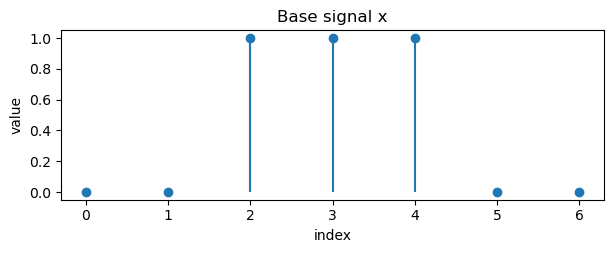

In [3]:
# A simple 1D "signal": a bump
x = np.array([0, 0, 1, 1, 1, 0, 0], dtype=float)

fig, ax = plt.subplots(figsize=(7, 2.2))
plot_1d(x, "Base signal x", ax=ax)
plt.show()


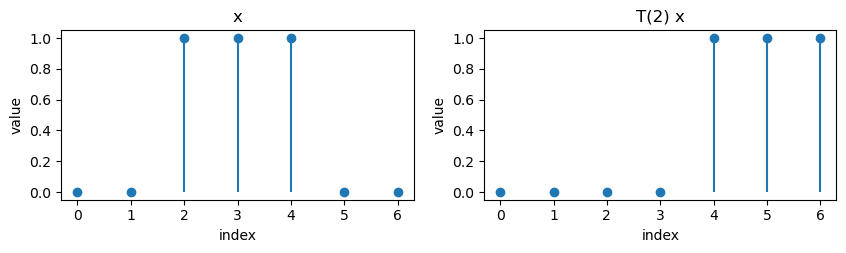

In [4]:
def T(k, n=None):
    """
    Translation / circular shift by k steps.
    Returns a function acting on 1D arrays.
    """
    def apply(x):
        m = len(x) if n is None else n
        return np.roll(x, shift=k, axis=0)[:m]
    return apply

# quick sanity check
x1 = T(2)(x)
fig, axs = plt.subplots(1, 2, figsize=(10, 2.2))
plot_1d(x, "x", ax=axs[0])
plot_1d(x1, "T(2) x", ax=axs[1])
plt.show()


In [5]:
def allclose(a, b, tol=1e-9):
    return np.allclose(a, b, atol=tol, rtol=0)

# composition: T(a)∘T(b) == T(a+b)
a, b = 2, -1
lhs = T(a)(T(b)(x))
rhs = T(a + b)(x)
assert allclose(lhs, rhs), "Composition failed for translations!"

# identity: T(0) == identity
assert allclose(T(0)(x), x), "Identity failed!"

# inverse: T(-k) is inverse of T(k)
k = 3
assert allclose(T(-k)(T(k)(x)), x), "Inverse failed!"

print("✅ Translation transformations pass: composition, identity, inverse.")


✅ Translation transformations pass: composition, identity, inverse.


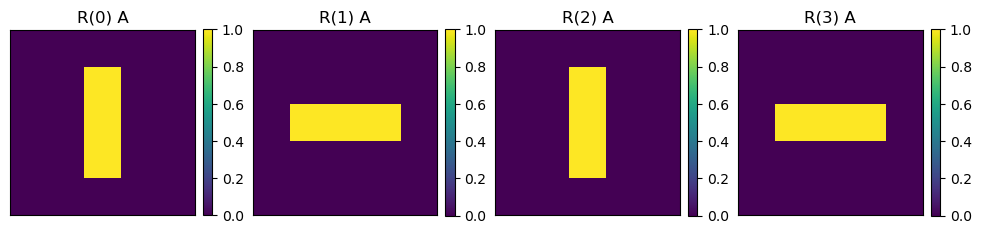

✅ 90° rotations behave as a finite group under composition.


In [6]:
A = np.zeros((5, 5))
A[1, 2] = 1.0
A[2, 2] = 1.0
A[3, 2] = 1.0  # a vertical bar

def R(q):
    """
    Rotation by 90° * q counterclockwise on a 2D grid.
    q in {0,1,2,3}.
    """
    q = q % 4
    def apply(A):
        return np.rot90(A, k=q)
    return apply

fig, axs = plt.subplots(1, 4, figsize=(12, 2.6))
for i in range(4):
    show_grid(R(i)(A), title=f"R({i}) A", ax=axs[i])
plt.show()

# verify closure by composition: R(a)∘R(b) == R(a+b)
for a in range(4):
    for b in range(4):
        lhs = R(a)(R(b)(A))
        rhs = R(a + b)(A)
        assert allclose(lhs, rhs), f"Rotation composition failed for a={a}, b={b}"
print("✅ 90° rotations behave as a finite group under composition.")


## Group vs group action

A group tells us which transformations exist and how they compose.

A **group action** tells us how those transformations act on a *particular kind of quantity*.

The same symmetry can act differently on:
- scalars (values stay the same)
- vectors (components transform)
- fields (values + coordinates may change)


In [7]:
# Scalar under rotation: unchanged (conceptually). If it's attached to the object, it stays the same number.
E = 3.14  # pretend "energy"
print("Scalar E:", E, " -> under rotation, still", E)

# Vector under rotation: transforms by a rotation matrix
def rot2d(theta_deg):
    theta = np.deg2rad(theta_deg)
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s],
                     [s,  c]])

v = np.array([1.0, 0.0])  # x-direction
R90 = rot2d(90)
print("Vector v:", v, " -> R90 v:", R90 @ v)


Scalar E: 3.14  -> under rotation, still 3.14
Vector v: [1. 0.]  -> R90 v: [0. 1.]


## Invariance tests

We will test whether a function satisfies:

\[
f(g \cdot x) = f(x)
\]

The point is not that these are “good models”.
The point is: **this is a checkable constraint**.


In [8]:
def f_sum(x):
    return np.sum(x)

def f_norm(x):
    return np.linalg.norm(x)

def f_center_of_mass(x):
    # this is NOT translation-invariant under circular shift
    idx = np.arange(len(x))
    return float(np.sum(idx * x) / (np.sum(x) + 1e-12))

tests = [("sum", f_sum), ("norm", f_norm), ("center_of_mass", f_center_of_mass)]

k = 2
x_shift = T(k)(x)

for name, f in tests:
    left = f(x_shift)
    right = f(x)
    ok = np.allclose(left, right, atol=1e-9, rtol=0)
    print(f"{name:>15}: f(Tx)={left:.6f}, f(x)={right:.6f}  ->  {'✅ invariant' if ok else '❌ not invariant'}")


            sum: f(Tx)=3.000000, f(x)=3.000000  ->  ✅ invariant
           norm: f(Tx)=1.732051, f(x)=1.732051  ->  ✅ invariant
 center_of_mass: f(Tx)=5.000000, f(x)=3.000000  ->  ❌ not invariant


## Equivariance tests

We will test whether an operator satisfies:

\[
f(g \cdot x) = g \cdot f(x)
\]

For translations, a fixed convolution is the classic example of an equivariant linear operator.


max |lhs-rhs| = 0.0
✅ Fixed convolution is translation-equivariant (with wrap boundary).


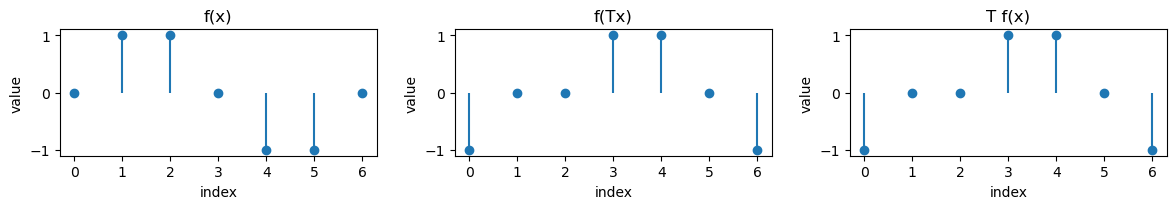

In [10]:
kernel = np.array([1.0, 0.0, -1.0])  # simple derivative-like filter

def conv_same(x, k):
    # "same" length via padding + valid conv
    pad = len(k) // 2
    xp = np.pad(x, (pad, pad), mode="wrap")  # wrap makes translation equivariance exact under circular shifts
    y = np.convolve(xp, k, mode="valid")
    return y

def f_conv(x):
    return conv_same(x, kernel)

kshift = 2
lhs = f_conv(T(kshift)(x))          # f(Tx)
rhs = T(kshift)(f_conv(x))          # T(f(x))

print("max |lhs-rhs| =", np.max(np.abs(lhs - rhs)))

assert np.allclose(lhs, rhs, atol=1e-9, rtol=0), "Convolution equivariance check failed!"
print("✅ Fixed convolution is translation-equivariant (with wrap boundary).")

fig, axs = plt.subplots(1, 3, figsize=(12, 2.2))
plot_1d(f_conv(x), "f(x)", ax=axs[0])
plot_1d(f_conv(T(kshift)(x)), "f(Tx)", ax=axs[1])
plot_1d(T(kshift)(f_conv(x)), "T f(x)", ax=axs[2])
plt.tight_layout()
plt.show()


In [11]:
def f_sort(x):
    return np.sort(x)

lhs = f_sort(T(2)(x))
rhs = T(2)(f_sort(x))

print("f_sort(Tx) =", lhs)
print("T(f_sort(x)) =", rhs)
print("allclose?", np.allclose(lhs, rhs))

# no assert here: it's supposed to fail


f_sort(Tx) = [0. 0. 0. 0. 1. 1. 1.]
T(f_sort(x)) = [1. 1. 0. 0. 0. 0. 1.]
allclose? False


## Permutations (graph-flavored)

For node features \(X \in \mathbb{R}^{n \times d}\), a permutation is a relabeling of nodes.

Equivariance requirement:

\[
f(PX) = P f(X)
\]

We'll test this for a simple node-wise linear map \(f(X) = XW\).


In [12]:
n, d, m = 4, 3, 2
X = np.arange(n*d).reshape(n, d).astype(float)

# a permutation of [0,1,2,3] -> [2,0,3,1]
perm = np.array([2, 0, 3, 1])

def perm_matrix(p):
    n = len(p)
    P = np.zeros((n, n))
    for i, j in enumerate(p):
        P[i, j] = 1.0
    return P

P = perm_matrix(perm)

W = np.array([[1.0, 0.0],
              [0.0, 1.0],
              [1.0, -1.0]])

def f_nodewise(X):
    return X @ W  # acts on features, independently per node

lhs = f_nodewise(P @ X)
rhs = P @ f_nodewise(X)

print("max |lhs-rhs| =", np.max(np.abs(lhs - rhs)))
assert np.allclose(lhs, rhs, atol=1e-9, rtol=0), "Permutation equivariance failed!"
print("✅ Node-wise linear map is permutation-equivariant.")


max |lhs-rhs| = 0.0
✅ Node-wise linear map is permutation-equivariant.


In [13]:
def bad_flatten_map(X):
    # A map that depends on the chosen ordering (very common failure mode)
    z = X.reshape(-1)          # flatten
    return z[:n]               # arbitrary slice (nonsense, but makes the point)

lhs = bad_flatten_map(P @ X)
rhs = P @ bad_flatten_map(X)

print("lhs =", lhs)
print("rhs =", rhs)
print("allclose?", np.allclose(lhs, rhs))


lhs = [6. 7. 8. 0.]
rhs = [2. 0. 3. 1.]
allclose? False


## Wrap-up

What you should take away:
- “Group” is the minimal bookkeeping for transformations.
- “Action” is how transformations touch a particular kind of quantity.
- Invariance and equivariance are **constraints you can test**.

### Optional exercises
1. Implement reflections on the 2D grid and verify the group-like properties.
2. Change boundary conditions in the convolution cell (`wrap` -> `constant`) and observe what breaks.
3. Write your own function that is invariant but *not* equivariant, and vice versa.
